In [2]:
from scipy.io import wavfile
import os

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import tensorflow as tf

import time

In [3]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"
NEW_INPUT_DIR = WORKING_DIR + "/input"
NEW_INPUT_AUDIO_DIR = NEW_INPUT_DIR + "/audio"
NEW_INPUT_SPECTROGRAM_DIR = NEW_INPUT_DIR + "/spectrogram"

# dataset
SAMPLE_RATE = 48_000
INPUT_SIZE = 65_536
TRAIN_PERCENTAGE = 0.8

# training
BATCH_SIZE = 256
# buffer size should be multiple of batch size
# for perfect shuffling, buffer size > data size
# data size = 30_000
BUFFER_SIZE = 30_080
EPOCHS = 1000
DATA_PERCENTAGE = 0.5

In [4]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)
    
if not os.path.exists(NEW_INPUT_DIR):
    os.mkdir(NEW_INPUT_DIR)

if not os.path.exists(NEW_INPUT_AUDIO_DIR):
    os.mkdir(NEW_INPUT_AUDIO_DIR)

if not os.path.exists(NEW_INPUT_SPECTROGRAM_DIR):
    os.mkdir(NEW_INPUT_SPECTROGRAM_DIR)

In [5]:
# set to True to run cells that are only meant for exploration
EXPLORING = False

FIRST_RUN = (not os.path.exists(NEW_INPUT_DIR)) or (len(os.listdir(NEW_INPUT_DIR)) < 3)

# Handle Given Data

Starting by checking how the data is stored

In [6]:
if EXPLORING:
    # each folder in INPUT_DIR is a different voice
    # read the first item of the first folder
    # and print the sample rate and the number of samples and the samples
    for folder in os.listdir(INPUT_DIR):
        sample_rate, samples = wavfile.read(os.path.join(INPUT_DIR, folder, os.listdir(os.path.join(INPUT_DIR, folder))[0]))
        print(f"Sample rate: {sample_rate}")
        print(f"Number of samples: {len(samples)}")
        print(f"Samples: {samples}")
        break

Check if the length of the sound is the same for every one of them

In [7]:
if EXPLORING:
    # check if the number of samples is the same for the 5 files
    pre_number_samples = None
    times = 0
    for folder in os.listdir(INPUT_DIR):
        # for each folder
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            _, samples = wavfile.read(os.path.join(INPUT_DIR, folder, file))
            num_samples = len(samples)
            if pre_number_samples is None:
                pre_number_samples = num_samples
            else:
                if pre_number_samples != num_samples:
                    print(f"Number of samples is not the same for all files in {folder}")
                    break

            print(f"Sample rate: {num_samples}")
            times += 1
            if times == 5:
                break
        break


it is not!

Let us check how it is distributed

100%|██████████| 61/61 [01:50<00:00,  1.82s/it]


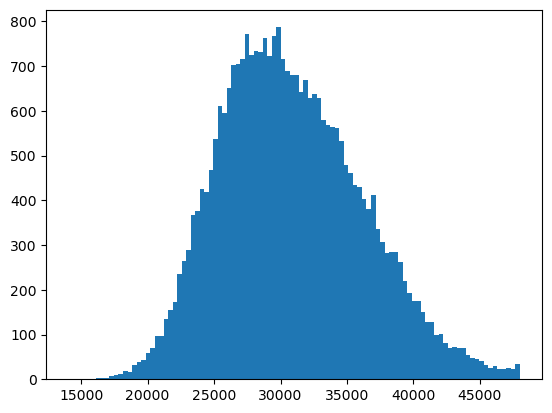

In [8]:
if FIRST_RUN:
    # given that the number of samples is not the same for all files, let's see
    # the distribution of the number of samples
    number_samples = []
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if folder is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            _, samples = wavfile.read(os.path.join(INPUT_DIR, folder, file))
            number_samples.append(len(samples))

    plt.hist(number_samples, bins=100)

Mean is around 30 000. Setting the size to 65_536 is good for the network, as seen afterwards and is above the max, no audio will be loss.

In [9]:
if EXPLORING:
    max_number_samples = max(number_samples)
    print(f"Max number of samples: {max_number_samples}")

So that the input is the same size for all instances, we pad them by stretching the last and first elmeent, centering the initial sound.

We are also storing these new sounds is a slightly different way. Each folder corresponds to a class, not to a speaker.

In [10]:
def create_same_size_raw_audios():
    # let's pad the samples
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            sample_rate, samples = wavfile.read(
                os.path.join(INPUT_DIR, folder, file))
            if len(samples) < INPUT_SIZE:
                # pad the samples on both sides
                samples = np.pad(samples, ((INPUT_SIZE - len(samples) + 1) //
                                 2, (INPUT_SIZE - len(samples)) // 2), mode='edge')

            # get the label
            label = file.split("_")[0]
            # creating the label folder if it does not exist
            if not os.path.exists(os.path.join(NEW_INPUT_AUDIO_DIR, label)):
                os.mkdir(os.path.join(NEW_INPUT_AUDIO_DIR, label))

            # normalize
            normalized_samples = samples / 32768

            wavfile.write(os.path.join(NEW_INPUT_AUDIO_DIR, label,
                          file), sample_rate, normalized_samples)
            
def create_spectrograms():
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            sample_rate, samples = wavfile.read(
                os.path.join(INPUT_DIR, folder, file))

            if len(samples) < INPUT_SIZE:
                # pad the samples on both sides
                samples = np.pad(samples, ((INPUT_SIZE - len(samples) + 1) //
                                 2, (INPUT_SIZE - len(samples)) // 2), mode='edge')
                
            # pass samples to float
            samples = tf.cast(samples, tf.float32)

            # get the label
            label = file.split("_")[0]
            # creating the label folder if it does not exist
            if not os.path.exists(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label)):
                os.mkdir(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label))
                
            # create the spectrogram
            spectrogram = tf.signal.stft(samples, frame_length=255, frame_step=128)
            spectrogram = tf.abs(spectrogram)
            
            # save the spectrogram
            np.save(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label, file), spectrogram.numpy())


if FIRST_RUN:    
    create_same_size_raw_audios()

100%|██████████| 61/61 [00:29<00:00,  2.09it/s]


In case one wants to reset the development, run the following cell.

In [11]:
if False:
    import shutil
    shutil.rmtree(NEW_INPUT_DIR)

Let us show an example of these new samples.

In [12]:
if EXPLORING:
    sample_rate, samples = wavfile.read(os.path.join(NEW_INPUT_DIR, "3", os.listdir(os.path.join(NEW_INPUT_DIR, "3"))[0]))
    plt.plot(samples)

# Handle New Data

In this section we will deal with this new data.

One cannot simply load them into an array because it would take too much memory.

A data pipeline is required: inspiration: https://www.tensorflow.org/guide/data

## Consuming Sets of Files

Our files are separated into folders, each folder contains its class.
We read the files according to the path.

In [13]:
import pathlib

audios_root = pathlib.Path(NEW_INPUT_AUDIO_DIR)

list_ds = tf.data.Dataset.list_files(str(audios_root/'*/*'))

def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

## Normalization

We normalize the data to values between -1 and 1, taking into account that the samples are in 16 bits. so the range is -32768 to 32767.

After normalization, a new sample is showed.

(65536, 1)


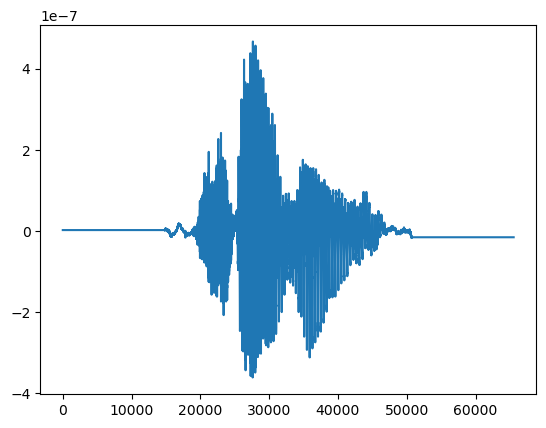

In [14]:
def normalize(samples):
    return samples / 32768

normalized_ds = labeled_ds.map(lambda x, y: (normalize(tf.audio.decode_wav(x, desired_channels=1).audio), y))

for audio, label in normalized_ds.take(1):
    print(audio.shape)
    plt.plot(audio.numpy())

In [15]:
# reduce the dataset to DATA_PERCENTAGE
reduced_ds = normalized_ds.take(int(DATA_PERCENTAGE * len(normalized_ds)))

# batch and shuffle the dataset
batch_ds = reduced_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# split into train and test
train_size = int(TRAIN_PERCENTAGE * len(batch_ds))
test_size = int((1 - TRAIN_PERCENTAGE) * len(batch_ds))
train_ds = batch_ds.take(train_size)
test_ds = batch_ds.skip(train_size)

# set train to only the X
# TODO temporary
train_ds = train_ds.map(lambda x, y: x)
test_ds = test_ds.map(lambda x, y: x)

In [16]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE, 1)),
                tf.keras.layers.Conv1D(
                    filters=32, kernel_size=9, strides=2, activation='relu'),
                tf.keras.layers.Conv1D(
                    filters=64, kernel_size=9, strides=2, activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=16384 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(16384, 32)),
                tf.keras.layers.Conv1DTranspose(
                    filters=64, kernel_size=9, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv1DTranspose(
                    filters=32, kernel_size=9, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv1DTranspose(
                    filters=1, kernel_size=9, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
          eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

    def generate_sample(self, test_sample, save=False, experiment_name="default", epoch=0):
        mean, logvar = self.encode(test_sample)
        z = self.reparameterize(mean, logvar)
        predictions = self.sample(z)

        if save:
            # create the folder if it doesnt exist
            folder_name = "{}/{}/{}".format(WORKING_DIR, self.MODEL_NAME, experiment_name)
            # create all folders recursively
            os.makedirs(folder_name, exist_ok=True)

            # save the audio
            wavfile.write("{}/epoch_{}.wav".format(folder_name, epoch), SAMPLE_RATE, generated_audio[0])

        # display the audio
        plt.plot(predictions[0])
        plt.show()


In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [18]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [1]:
def normalize(samples):
    return samples / 32768


# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
# take num_examples_to_generate samples from the test set
for test_batch in test_ds.take(1):
    test_sample = test_batch[0:num_examples_to_generate]

    # normalize the samples
    # for each sample in test_sample
    test_sample = tf.map_fn(lambda sample: normalize(tf.audio.decode_wav(
        sample, desired_channels=1).audio), test_sample, dtype=tf.float32)

#test_sample = tf.convert_to_tensor([test_sample])
print(test_sample.shape)


NameError: name 'BATCH_SIZE' is not defined

In [20]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32764, 32)         320       
                                                                 
 conv1d_1 (Conv1D)           (None, 16378, 64)         18496     
                                                                 
 flatten (Flatten)           (None, 1048192)           0         
                                                                 
 dense (Dense)               (None, 4)                 4192772   
                                                                 
Total params: 4,211,588
Trainable params: 4,211,588
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 524288)            1572864   
                                                                 
 reshape (Reshape)           (None, 16384, 32)         0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 32768, 64)        18496     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 65536, 32)        18464     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 65536, 1)         289       
 ranspose)                                                       
                                                      

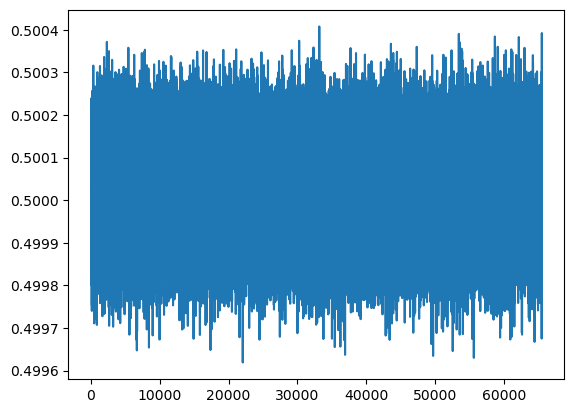

  0%|          | 0/3 [00:00<?, ?it/s]

1
2



100%|██████████| 47/47 [01:20<00:00,  1.71s/it]


3
4
5
6
7
Epoch: 1, Test set ELBO: -22935.017578125, time elapse for current epoch: 80.48377895355225
8


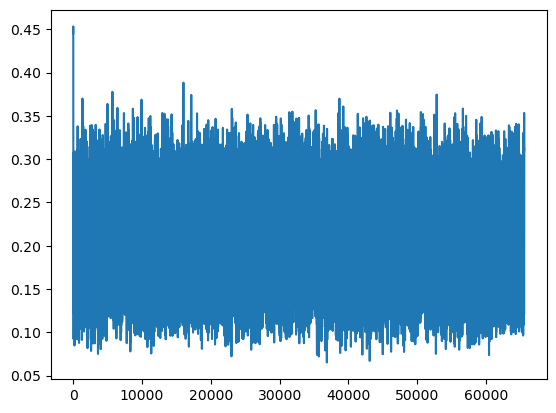

 33%|███▎      | 1/3 [02:02<04:04, 122.08s/it]

9
1
2



100%|██████████| 47/47 [01:15<00:00,  1.61s/it]


3
4
5
6
7
Epoch: 2, Test set ELBO: -4446.4580078125, time elapse for current epoch: 75.90325331687927
8


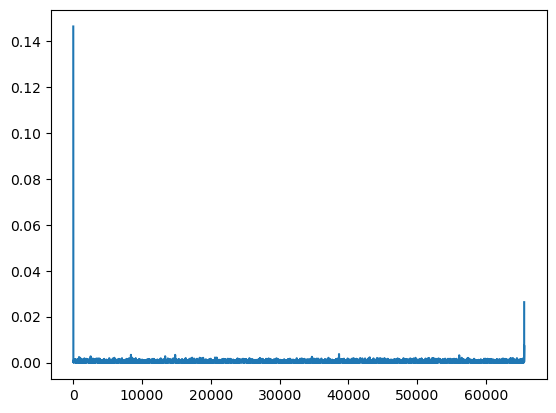

 67%|██████▋   | 2/3 [04:40<02:23, 143.29s/it]

9
1
2



  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
model.generate_sample(test_sample)

epochs = 3

for epoch in tqdm(range(1, epochs + 1)):
  start_time = time.time()
  for train_x in tqdm(train_ds):
    # each train_x is of shape (BATCH_SIZE, )
    # where each element is an array
    # of shape (SAMPLE_LENGTH, 1)
    
    # now, we transform it into a tensor of shape (BATCH_SIZE, SAMPLE_LENGTH, 1)
    train_x = normalize(tf.audio.decode_wav(
        train_x, desired_channels=1).audio)
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_ds:
    loss(compute_loss(model, test_x))

  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  model.generate_sample(test_sample, epoch=epoch)
